In [333]:
import requests
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

###Download train and test file

In [314]:
links = ['https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data',
        'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test']

for i in links:
    r = requests.get(i)
    with open(os.path.basename(i)+'.csv', "wb") as code:
        code.write(r.content)

In [334]:
df = pd.read_csv('adult.data.csv',names = ['age','workclass','fnlwgt','education','education_num','marital_status',
                                             'occupation','relationship','race','sex','capital_gain','capital_loss',
                                           'hours_week','native_country','income'])

In [335]:
df.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [336]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education_num     32561 non-null int64
marital_status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital_gain      32561 non-null int64
capital_loss      32561 non-null int64
hours_week        32561 non-null int64
native_country    32561 non-null object
income            32561 non-null object
dtypes: int64(6), object(9)
memory usage: 4.0+ MB


In [337]:
df = df.replace(' ?',np.nan)

In [338]:
#drop columns that we dont need
df.drop(['fnlwgt','education_num'],inplace=True,axis=1)

In [339]:
#convert categorical, for seaborn
for i in df[list(df.iloc[:,1:8]) + list(df.iloc[:,11:12])]:
    df[i] = df[i].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32561 entries, 0 to 32560
Data columns (total 13 columns):
age               32561 non-null int64
workclass         30725 non-null category
education         32561 non-null category
marital_status    32561 non-null category
occupation        30718 non-null category
relationship      32561 non-null category
race              32561 non-null category
sex               32561 non-null category
capital_gain      32561 non-null int64
capital_loss      32561 non-null int64
hours_week        32561 non-null int64
native_country    31978 non-null category
income            32561 non-null object
dtypes: category(8), int64(4), object(1)
memory usage: 1.7+ MB


##Lets graph the data to see the relationship

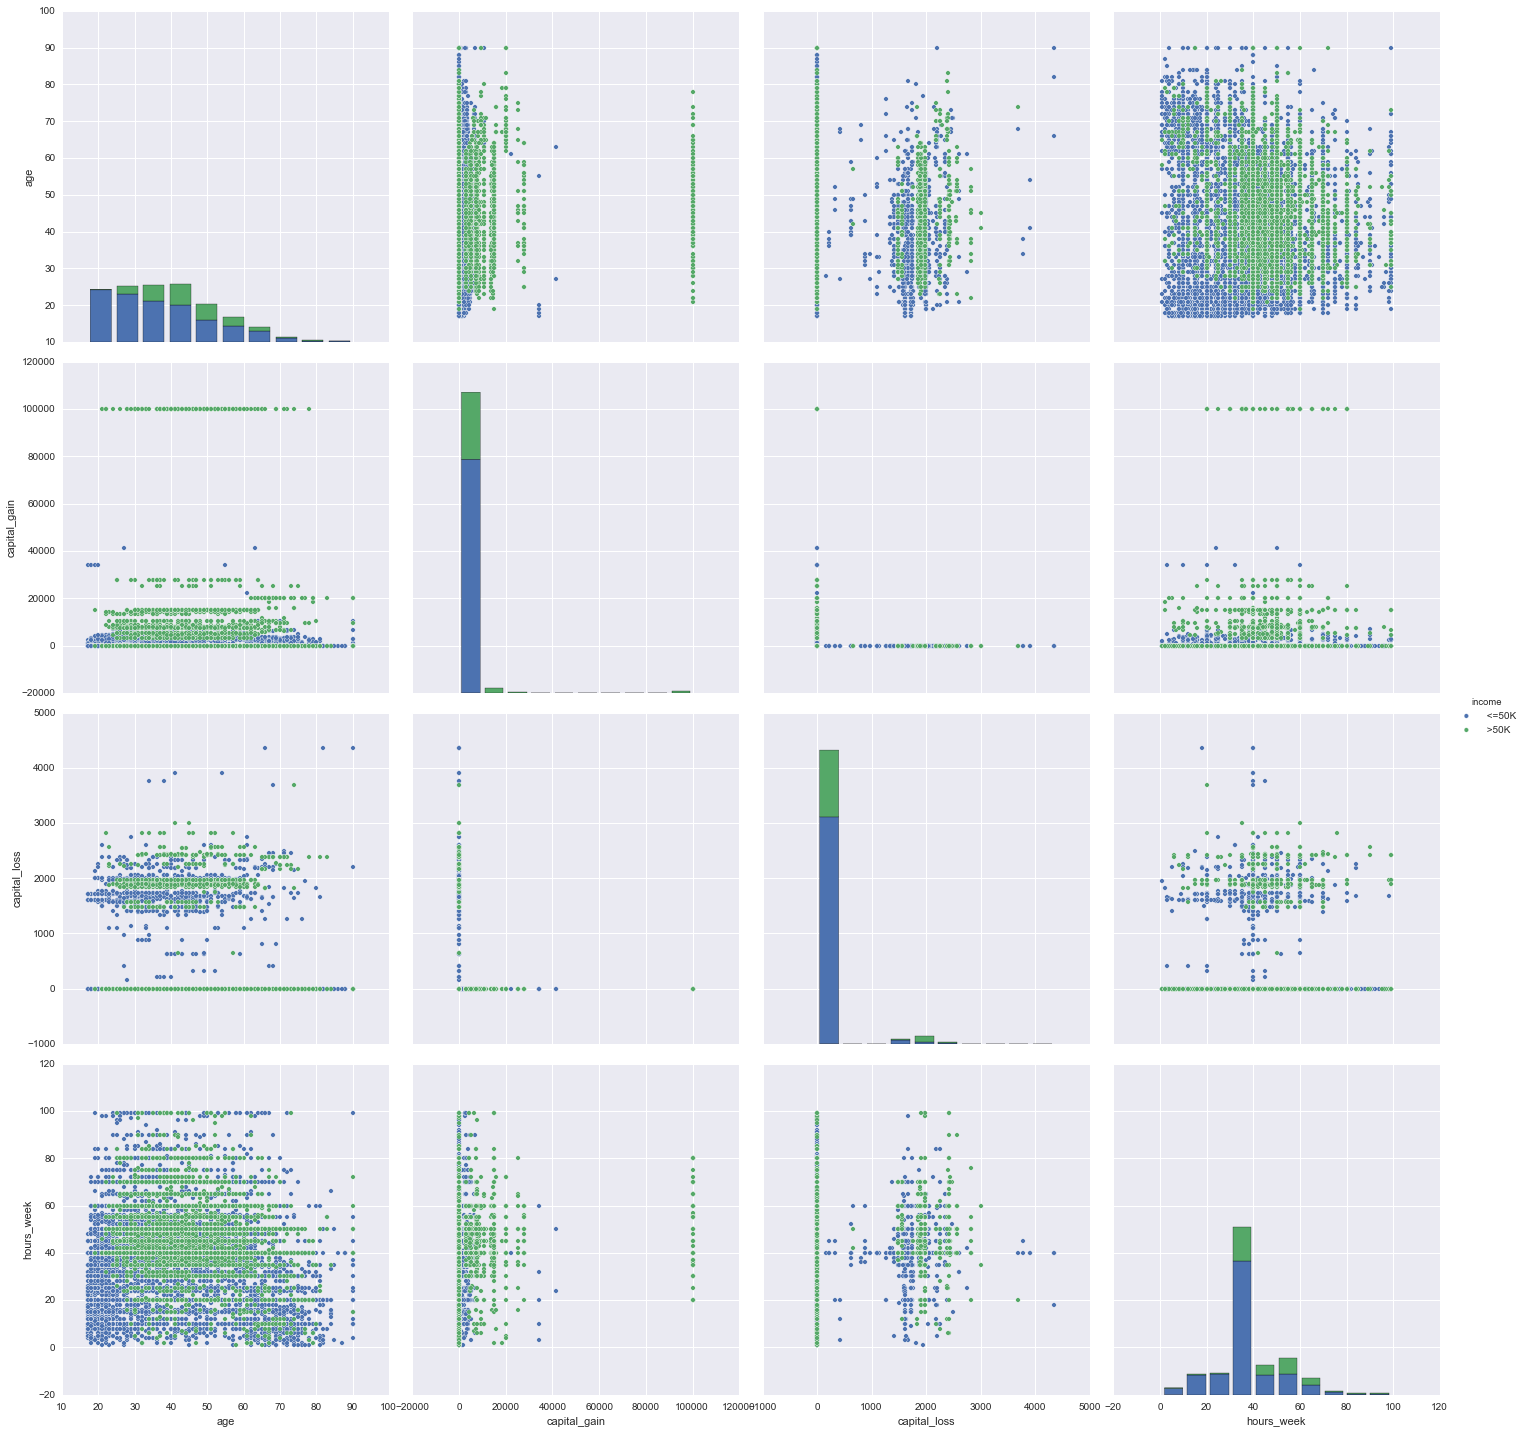

In [340]:
#start with factor plot
sns.pairplot(df,hue='income',size = 5)

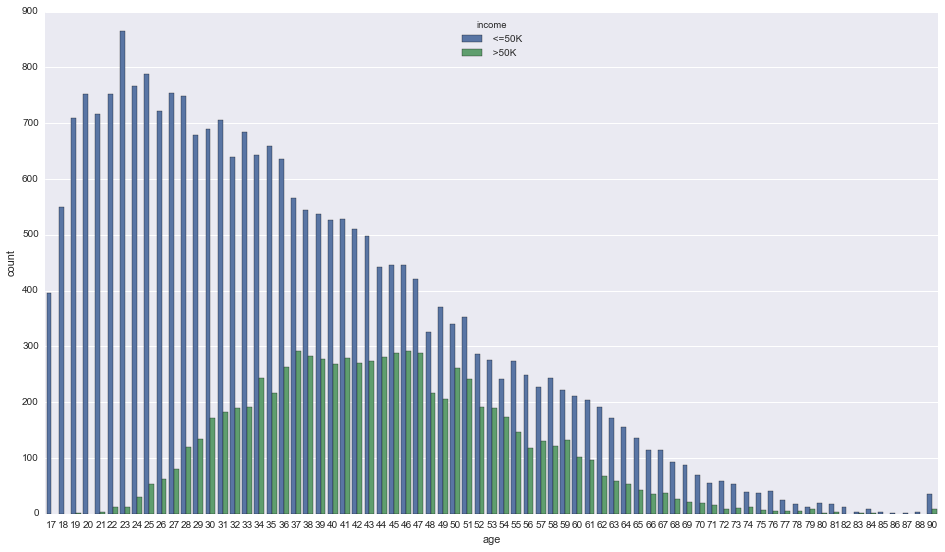

In [341]:
#Age and income
f, ax = plt.subplots(figsize=(16, 9))
sns.countplot(x='age', data = df[['age','income']].sort(['age']), hue='income')

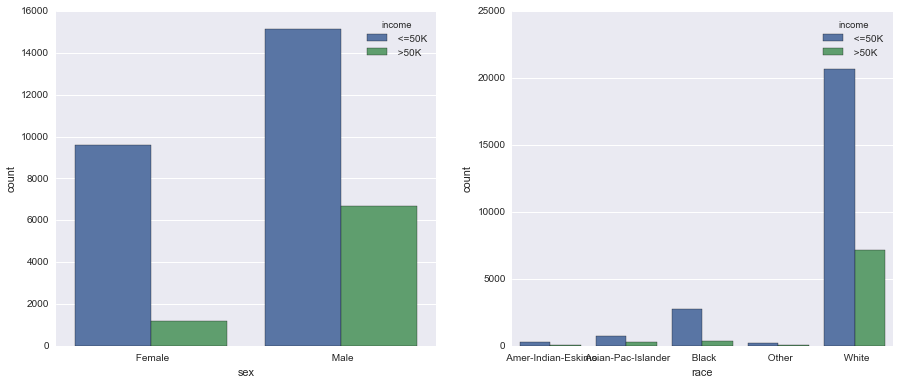

In [342]:
#barplot hours related to race and sex
#men and over
f, (ax) = plt.subplots(1,2, figsize =(15,6))#,sharey=True)
#plt.subplots(figsize=(16, 9))
sns.countplot(x="sex", data=df,ax =ax[0] ,hue='income')#, palette = 'muted')
sns.countplot(x="race",data=df,ax =ax[1] ,hue='income')#,palette = 'purple')


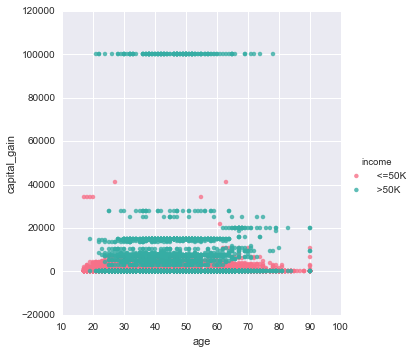

In [343]:
sns.lmplot(x="age",y='capital_gain' ,data=df,hue='income',fit_reg = False, palette = 'husl')

###From these graphs we can deduce a few assumptions about the independent variables
### -Most people making >50ks are in the mid 40's 
### -Most people making >50k are Male and white
### ->50k on avg work more than 40 hours
### ->50k have more capital gains

#Machine Learning

##Lets use CART

In [344]:
df_noNaN = df.dropna()


In [345]:
y_full_noNaN = df_noNaN.pop('income')
X_full_noNaN = pd.get_dummies(df_noNaN)



In [346]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.cross_validation import cross_val_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz


estimator = DecisionTreeClassifier()
score = cross_val_score(estimator, X_full_noNaN, y_full_noNaN ).mean()
print("Score with the entire dataset = %.2f" % score)

Score with the entire dataset = 0.81


In [347]:
# Estimate the score after imputation of the missing values
y_missing = df['income']
X_missing = pd.get_dummies(df.iloc[:,:-1])



estimator = Pipeline([("imputer", Imputer(missing_values='NaN',
                                          strategy="mean",
                                          axis=0)),
                      ("CART", DecisionTreeClassifier())])
score = cross_val_score(estimator, X_missing, y_missing).mean()
print("Score after imputation of the missing values = %.2f" % score)

Score after imputation of the missing values = 0.82


##Lets Imputation barely help but lets continue using it

In [332]:
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)

array([[ 6.5,  2. ],
       [ 6. ,  4. ],
       [ 7. ,  6. ]])

In [348]:
X = imp.fit_transform(pd.get_dummies(df.iloc[:,:-1]))
Y = df['income'].map({" <=50K": 0, " >50K": 1})

In [351]:
from sklearn.cross_validation import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

modelCART = DecisionTreeClassifier(max_depth=2)

modelCART.fit(X_train,Y_train)

export_graphviz(modelCART, feature_names=pd.get_dummies(df.iloc[:,:-1]).columns)

In [352]:
import pydotplus


graph = pydotplus.graph_from_dot_file('tree.dot')
graph.write_png('tree.png')

True

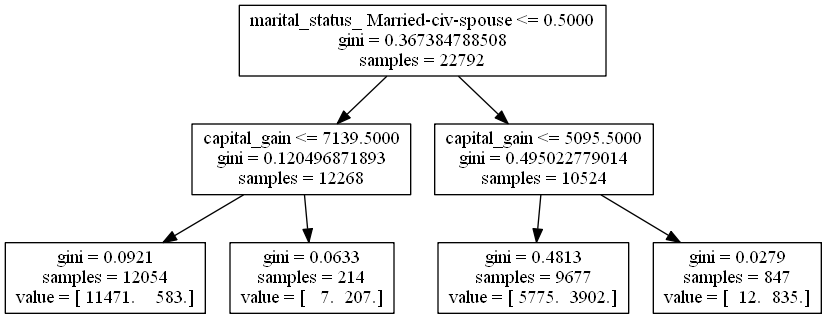

In [353]:
from IPython.display import Image
Image("tree.png", unconfined=True)

In [354]:
predCart = modelCART.predict(X_test)

In [355]:
from sklearn import metrics

metrics.mean_absolute_error(Y_test, predCart)

0.19111475074214351

In [357]:
param1 = ['entropy', 'gini']
param2 = range(3,15,2)

print 'CART Models\n'
for i in param1:
    for v in param2:
        model = DecisionTreeClassifier(criterion = i,max_depth=v)
        model.fit(X_train,Y_train)
        MAE = metrics.mean_absolute_error(Y_test,model.predict(X_test))
        print 'CART Model with {0} with Max depth of {1}  MAE: {2:.4f}'.format(i,v,MAE)
        export_graphviz(model, out_file = 'CART_{0}_{1}.dot'.format(i,v) ,feature_names=pd.get_dummies(df.iloc[:,:-1]).columns)
        graph = pydotplus.graph_from_dot_file('CART_{0}_{1}.dot'.format(i,v))
        graph.write_png('CART_{0}_{1}.png'.format(i,v))

CART Models

CART Model with entropy with Max depth of 3  MAE: 0.1763
CART Model with entropy with Max depth of 5  MAE: 0.1544
CART Model with entropy with Max depth of 7  MAE: 0.1465
CART Model with entropy with Max depth of 9  MAE: 0.1443
CART Model with entropy with Max depth of 11  MAE: 0.1462
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.882019 to fit

CART Model with entropy with Max depth of 13  MAE: 0.1472
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.66381 to fit

CART Model with gini with Max depth of 3  MAE: 0.1761
CART Model with gini with Max depth of 5  MAE: 0.1531
CART Model with gini with Max depth of 7  MAE: 0.1462
CART Model with gini with Max depth of 9  MAE: 0.1424
CART Model with gini with Max depth of 11  MAE: 0.1442
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.956114 to fit

CART Model with gini with Max depth of 13  MAE: 0.1446
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.663447 to fit

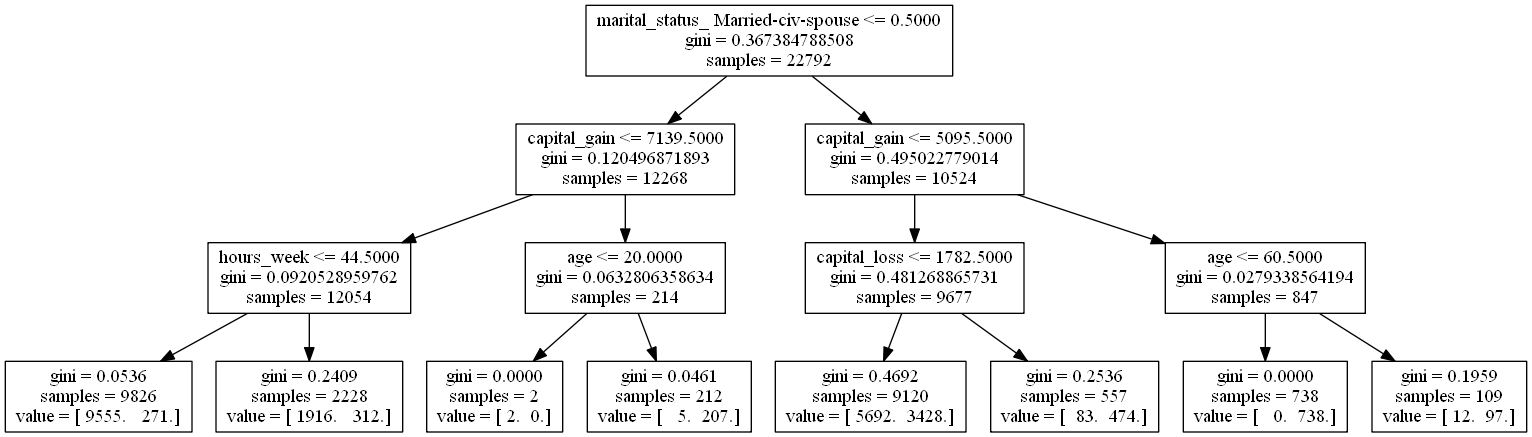

In [411]:
#look through the CART images
from IPython.display import Image
Image("CART_gini_3.png", unconfined=True)

###Lets try on our test data, Criterion = gini and max_depth = 9

In [400]:
modelCARTFin = DecisionTreeClassifier(criterion = 'gini',max_depth = 9)
modelCARTFin.fit(X_train,Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')

In [401]:
dftest = pd.read_csv('adult.test.csv',names = ['age','workclass','fnlwgt','education','education_num','marital_status',
                                             'occupation','relationship','race','sex','capital_gain','capital_loss',
                                           'hours_week','native_country','income'], skiprows = 1)

In [402]:
dftest.drop(['fnlwgt','education_num'],inplace=True,axis=1)

In [403]:
dftest = dftest.replace(' ?',np.nan)

In [404]:
pd.get_dummies(df.iloc[:,:-1]).columns.difference(pd.get_dummies(dftest.iloc[:,:-1]).columns)

Index([u'native_country_ Holand-Netherlands'], dtype='object')

In [405]:
X_dftest = pd.get_dummies(dftest.iloc[:,:-1])
X_dftest[pd.get_dummies(df.iloc[:,:-1]).columns.difference(X_dftest.columns)[0]] = 0

In [406]:
X_dftest = X_dftest[pd.get_dummies(df.iloc[:,:-1]).columns]

In [407]:
X_dftest = imp.fit_transform(X_dftest)
Y_dftest = dftest['income'].map({" <=50K.": 0, " >50K.": 1})


In [408]:
pred = modelCARTFin.predict(X_dftest)

In [409]:
MAE = metrics.mean_absolute_error(Y_dftest,pred)

In [410]:
MAE

0.14182175542042871